add this javascript blurb to all us to use SublimeText shortcuts and multi-line editing:

In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
    
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [ ]:
# figure out names for the deep datasets ...

In [63]:
# ! ssh ghpcc ls /nl/umw_job_dekker/users/ba69w/HiC_Analysis/U54_matrix/results/pairs_library
# ! ssh ghpcc ls /nl/umw_job_dekker/users/ba69w/HiC_Analysis/U54_deep/results/pairs_library/*hg38.dedup.stats

### pre-process stats data from all of the availabe samples

here is an inefficient script that is used to extract/clean stats information - probably would be easier to just read all of the related stats file into memory and handle them that way - but it does not matter now:
```sh
get_stats () {
    f=$1
    chrom=$2
    dataset=$3
    chrom_cis="$chrom/$chrom\s"
    sample=$(echo $f | cut -f1 -d  "_");
    tot=$(grep "total_nodups" $f | cut -f2);
    cis=$(grep '^cis[^_]' $f | cut -f2);
    trans=$(grep "^trans" $f | cut -f2);
    unmapped=$(grep "total_unmapped" $f | cut -f2);
    dups=$(grep "total_dups" $f | cut -f2);
    allM=$(grep -P "$chrom(\/|\s)" $f | awk '{s+=$2} END {print s}' );
    cisM=$(grep "$chrom_cis" $f | cut -f2);
    transM=$(grep -P "($chrom\/chr[[:alnum:]]*\t|chr[[:alnum:]]*\/$chrom\t)" $f | grep -v $chrom_cis | awk '{s+=$2} END {print s}');
    contigM=$(grep -P "$chrom(\/|\s)" $f | grep -vP "($chrom\/chr[[:alnum:]]*\t|chr[[:alnum:]]*\/$chrom\t)" | grep -v $chrom_cis | awk '{s+=$2} END {print s}');
    [[ -n $allM ]] || allM="0";
    [[ -n $cisM ]] || cisM="0";
    [[ -n $transM ]] || transM="0";
    [[ -n $contigM ]] || contigM="0";
    AA=$(( $cisM+$contigM+$transM ));
    [[ "$AA" == "$allM" ]] || echo "$f $chrom not-equal" >> ~/bbb/log.log;
    awk -v a="$sample" -v b="$tot" -v ba="$cis" -v bb="$trans" -v bc="$unmapped" -v bd="$dups" -v c="$allM" -v d="$cisM" -v e="$transM" -v f="$contigM" -v dt="$dataset" 'BEGIN {print a" "b" "ba" "bb" "bc" "bd" "c" "d" "e" "f" "dt }';
}


for chrom in $(cat ~/hg38.chroms  | cut -f1 -d" " | cut -f2 -d">"); do
    awk 'BEGIN {print "name tot cis trans unmapped dups all_chrom cis_chrom trans_chrom contig_chrom dataset_type" }' > ~/bbb/$chrom.tsv;
    cd /nl/umw_job_dekker/users/ba69w/HiC_Analysis/U54_matrix/results/pairs_library
    for f in  *hg38.dedup.stats; do
        get_stats $f $chrom shallow >> ~/bbb/$chrom.tsv
    done

    cd /nl/umw_job_dekker/users/ba69w/HiC_Analysis/U54_deep/results/pairs_library
    for f in  *hg38.dedup.stats; do
        get_stats $f $chrom deep >> ~/bbb/$chrom.tsv
    done
done

```

In [2]:
### Reading data in from the cluster ghpcc ...
### yeah - the input data is pre-processed from the pairs.stats
### pre-processed data includes more than will be in the paper

chroms = !ssh ghpcc cat /home/sv49w/hg38.chroms | cut -f1 -d" " |cut -f2 -d">"

_global_data = {}
for chrom in chroms:
    dat = !ssh ghpcc cat /home/sv49w/bbb_Mar2021_archive/{chrom}.tsv
    _global_data[chrom] = "\n".join(dat)

In [5]:
### some imports of what we are going to use
%matplotlib inline
# import ipywidgets as widgets
# %matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import seaborn as sns

import numpy as np

from io import StringIO

### more visualization related stuff - not that important after all
### the main author is going to compile/update everyhting using vector graphics editor
import seaborn as sns
sns.set()
sns.set_context("paper")

In [28]:
### some functions that we'll use:

def split_counts_fracs(counts):
    c_fracs = [_c for _c in counts if "frac_" in _c]
    c_counts = [_c for _c in counts if "frac_" not in _c]
    return c_fracs,c_counts

def parse_data(chrom):
    df = pd.read_csv(StringIO(_global_data[chrom]),sep=" ")
    # let's parse "name" into cell-type, enzyme, crosslink etc
    #
    # first one: cis+trans = tot (mapped)
    assert (df[["cis","trans"]].sum(axis=1) == df["tot"]).all()
    # second sanity check : allM = cisM + transM + contigM
    assert (df[["cis_chrom","trans_chrom","contig_chrom"]].sum(axis=1) == df["all_chrom"]).all()

    # df["cis_perc"] = df["cis"]/df["tot"]
    # df["ct_chrom"] = df["cis_chrom"]+df["trans_chrom"]+df["contig_chrom"]
    df["frac_tc"] = df["trans_chrom"]/df["cis_chrom"]
    df["frac_ta"] = df["trans_chrom"]/df["all_chrom"]
    return df.rename({"cross":"crosslink"})

def probe_for_double_digest(some_array,some_index):
    # if it's a single digest
    first_enzyme = some_array[some_index]
    # probe for the next element:
    try:
        _probe = some_array[some_index+1]
    except IndexError:
        return first_enzyme
    # if the probe works, check if it looks like
    # an enzyme:  
    if _probe in ['DdeI','DpnII','HindIII','MNase']:
        second_enzyme = _probe
        print(f"ooh !ohh! looks like double digest ! {first_enzyme} and {second_enzyme} ")
        return f"{first_enzyme}-{second_enzyme}"
    else:
        return first_enzyme
        
    
    

def parse_u54_names(name_split):
    exptype = name_split[0]
    celltype = name_split[1]
    if (exptype == "ENCODE") and (celltype=="HeLa"):
        cross = "FA"
        enzyme = probe_for_double_digest(name_split,2)
        cycle = "NS"        
    elif (exptype == "U54") and (celltype == "HFFc6"):
        if name_split[2] in ["p17","p22"]:
            cross = name_split[3]
            enzyme = probe_for_double_digest(name_split,4)
        else:
            cross = name_split[2]
            enzyme = probe_for_double_digest(name_split,3)
        cycle = "NS"
    elif (exptype == "U54") and (celltype in ["END4DN", "H1ESC4DN", "HFFc64DN"]):
        cross = name_split[3]
        enzyme = probe_for_double_digest(name_split,4)
        cycle = "NS"        
    elif celltype in ["END","ESC","END4DN","ESC4DN","H1ESC4DN","ENDMaehr","hEND4DN","PFE"]:
        cross = name_split[2]
        enzyme = probe_for_double_digest(name_split,3)
        cycle = "NS"
    elif celltype in "HFF":
        cross = name_split[3]
        enzyme = probe_for_double_digest(name_split,4)
        cycle = "NS"
    elif celltype == "HelaS3":
        cross = name_split[3]
        enzyme = probe_for_double_digest(name_split,4)
        cycle = name_split[2]
    else:
        print("I'm something else - deal with me...")
        print(name_split)
        ret = {}
    # do some typo correction in the sample names ....
    if enzyme == "HindIIII":
        enzyme = "HindIII"
    # simply print out unusual enzymes ...
    if enzyme not in ['DdeI','DpnII','HindIII','MNase']:
        print(f"exotic enzyme detected: {enzyme} in {name_split}")
    if cross not in ['DSG','EGS','FA']:
        print("cross",cross,name_split)
    if cycle not in ['NS','G1','M']:
        print("cycle",cycle,name_split)
    ret = {"cell":celltype, "cycle": cycle, "cross": cross, "enzyme": enzyme}
    return pd.Series(ret).rename({"cross":"crosslink"})

# this should be the same for all of them, but it's ugly this way ...
cell_cycle_cross_enzyme = parse_data("chrM")["name"].str.split("-").apply(parse_u54_names)

eexotic enzyme detected: NcoI ['U54', 'END', 'FA', 'NcoI', '20161014', 'R1', 'T1']
eexotic enzyme detected: NcoI ['U54', 'ESC', 'FA', 'NcoI', '20161018', 'R1', 'T1']
eexotic enzyme detected: MboI ['U54', 'HFF', 'beads', 'DSG', 'MboI', '20161219', 'R1', 'T1']
eexotic enzyme detected: MboI ['U54', 'HFF', 'beads', 'DSG', 'MboI', '20161219', 'R1', 'T2']
eexotic enzyme detected: NcoI ['U54', 'HFF', 'beads', 'DSG', 'NcoI', '20161014', 'R1', 'T1']
eexotic enzyme detected: MboI ['U54', 'HFF', 'beads', 'EGS', 'MboI', '20161219', 'R1', 'T1']
eexotic enzyme detected: NcoI ['U54', 'HFF', 'beads', 'EGS', 'NcoI', '20161014', 'R1', 'T1']
eexotic enzyme detected: MboI ['U54', 'HFF', 'beads', 'FA', 'MboI', '20161219', 'R1', 'T1']
eexotic enzyme detected: MflI ['U54', 'HFF', 'beads', 'FA', 'MflI', '20160930', 'R1', 'T1']
eexotic enzyme detected: NcoI ['U54', 'HFF', 'beads', 'FA', 'NcoI', '20161014', 'R1', 'T1']
eexotic enzyme detected: NheI ['U54', 'HFF', 'beads', 'FA', 'NheI', '20160930', 'R1', 'T1']
e

In [29]:
### just showing ALL available celllines/enzymes and crosslinkers:
for c in cell_cycle_cross_enzyme.columns:
    print(c,cell_cycle_cross_enzyme[c].unique())

cell ['END' 'ESC' 'HelaS3' 'HFF' 'PFE' 'HeLa' 'END4DN' 'ENDMaehr' 'ESC4DN'
 'H1ESC4DN' 'hEND4DN' 'HFFc64DN' 'HFFc6']
cycle ['NS' 'G1' 'M']
crosslink ['DSG' 'EGS' 'FA']
enzyme ['DdeI' 'DpnII' 'HindIII' 'MNase' 'NcoI' 'MboI' 'MflI' 'NheI' 'PspXI'
 'SgrAI' 'SgrDI' 'DdeI-DpnII']


In [30]:
### prepare the data :

# we are going to be caclulating some metrics for chrM
# we can also see how it looks for other ("good") chromosomes:
    
def prepare_plotting_data(
    enzymes,
    cells,
    cycles,
    crosslinkers,
    chrom="chrM",
    counts=["cis_chrom","trans_chrom","cis","trans","frac_tc"], # counts to be used in the metrics
    normalized = True,
):
    if chrom != "chrM":
        print("you'relooking at 'good' chromosomes !")
        print("data shouldn't be interpreted as a measure of random ligations")

    # this is just to make us able to change chroms
    # this is using GLOBAL variable
    df = parse_data(chrom)

    # this is using GLOBAL variable
    c1 = cell_cycle_cross_enzyme["enzyme"].isin(enzymes)
    c2 = cell_cycle_cross_enzyme["cell"].isin(cells)
    c3 = cell_cycle_cross_enzyme["cycle"].isin(cycles)
    c4 = cell_cycle_cross_enzyme["crosslink"].isin(crosslinkers)
    
    # consider only requested enz,cells,cycles,cross-es:
    ccce = cell_cycle_cross_enzyme[c1&c2&c3&c4]
    
    # here we're just treating additive columns differently than fractions:
    # no need to normalize the latter ...
    if normalized:
        c_fracs,c_counts = split_counts_fracs(counts)
        df_norm = df[c_counts]/df[["tot"]].values
        loc_df = pd.merge(df_norm,ccce,left_index=True,right_index=True)
        loc_df = pd.merge(loc_df,df[c_fracs],left_index=True,right_index=True)
    else:
        df_norm = df[counts]
        loc_df = pd.merge(df_norm,ccce,left_index=True,right_index=True)
        
    return loc_df



## Let's show ALL of the data using standard plotting functions from seaborn:

cell ['ESC' 'ESC4DN']
cycle ['NS']
crosslink ['FA']
enzyme ['DdeI' 'DpnII' 'HindIII' 'MNase' 'NcoI']


(-0.40017252566197437, 42.753687770026175)

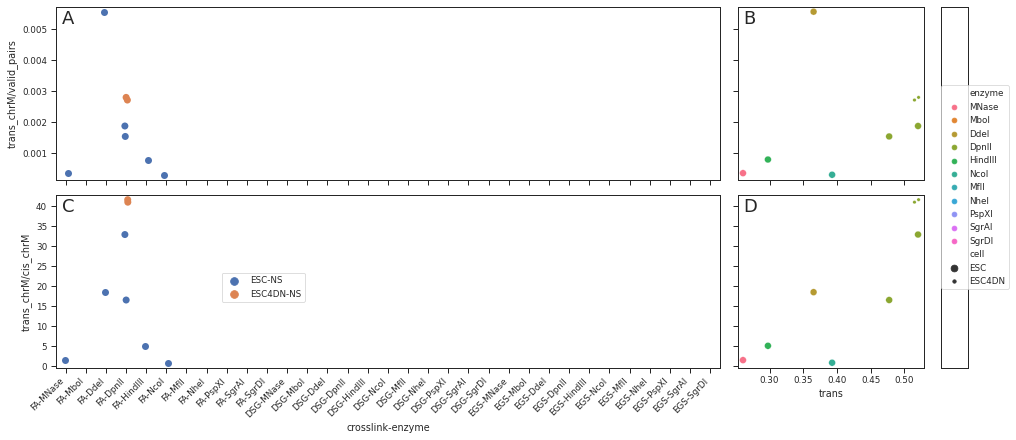

In [31]:
fig1 = plt.figure(figsize=(14,6),constrained_layout=True)
spec1 = gridspec.GridSpec(ncols=3,nrows=2,figure=fig1,height_ratios=[1,1], width_ratios=[5,1.4,0.2])
# # Also make sure the margins and spacing are apropriate
# spec1.update(left=0.05, right=0.95, bottom=0.08, top=0.93, wspace=0.02, hspace=0.03)
# # BUT: this is irrelevant for the saved image, if using bbox_inches='tight'in savefig !
ax1 = fig1.add_subplot(spec1[0,0])
ax2 = fig1.add_subplot(spec1[1,0])

ax1s = fig1.add_subplot(spec1[0,1])
ax2s = fig1.add_subplot(spec1[1,1])

axl = fig1.add_subplot(spec1[:,2])

chrom="chrM"
# enzymes = ['DdeI' ,'DpnII' ,'HindIII' ,'MNase' ,'NcoI' ,'MboI' ,'MflI' ,'NheI' ,'PspXI','SgrAI','SgrDI']
# size_order = ['MNase' ,'MboI' ,'DdeI' ,'DpnII' ,'HindIII' ,'NcoI' ,'MflI' ,'NheI' ,'PspXI','SgrAI','SgrDI']
# cells = ['END','ESC','HelaS3','HFF','PFE','HeLa','END4DN','ENDMaehr','ESC4DN','H1ESC4DN','hEND4DN','HFFc64DN','HFFc6']
# cycle = ['NS','G1','M']
# cross = ['DSG','EGS','FA']

enzymes = ['DdeI' ,'DpnII' ,'HindIII' ,'MNase' ,'NcoI' ,'MboI' ,'MflI' ,'NheI' ,'PspXI','SgrAI','SgrDI']
size_order = ['MNase' ,'MboI' ,'DdeI' ,'DpnII' ,'HindIII' ,'NcoI' ,'MflI' ,'NheI' ,'PspXI','SgrAI','SgrDI']
# cells = ['HFF','HFFc64DN','HFFc6']
cells = ['ESC','ESC4DN','H1ESC4DN']
cycle = ['NS','G1','M']
cross = ['FA',]


grp = "crosslink-enzyme_cell-cycle".split("_")
log=False

# prep the data with selected cell/enz/cross etc and normalized metrics for a given chrom (chrM for random ligation est.):
loc_df = prepare_plotting_data(enzymes, cells, cycle, cross, chrom=chrom,
                               counts=["cis_chrom","trans_chrom","cis","trans","frac_tc"], # counts to be used in the metrics
                               normalized = True
                              )

loc_df["cell-cycle"] = loc_df[["cell","cycle"]].apply(lambda x: "-".join(x),axis=1)
loc_df["crosslink-enzyme"] = loc_df[["crosslink","enzyme"]].apply(lambda x: "-".join(x),axis=1)

# just print whatever is going to end up on the plot:
for c in cell_cycle_cross_enzyme.columns:
    print(c,loc_df[c].unique())

# just manually setting an order for the visualization:
order=['FA-MNase','FA-MboI','FA-DdeI','FA-DpnII','FA-HindIII','FA-NcoI','FA-MflI','FA-NheI','FA-PspXI','FA-SgrAI','FA-SgrDI']
order+=['DSG-MNase','DSG-MboI','DSG-DdeI','DSG-DpnII','DSG-HindIII','DSG-NcoI','DSG-MflI','DSG-NheI','DSG-PspXI','DSG-SgrAI','DSG-SgrDI']
order+=['EGS-MNase','EGS-MboI','EGS-DdeI','EGS-DpnII','EGS-HindIII','EGS-NcoI','EGS-MflI','EGS-NheI','EGS-PspXI','EGS-SgrAI','EGS-SgrDI']

# order of colors:
hue_order=["ESC-NS","END-NS","HFF-NS","HelaS3-NS","HelaS3-G1","HelaS3-M"]
sns.stripplot(hue="cell-cycle", y='trans_chrom', x="crosslink-enzyme",order=order, size=7, data=loc_df, ax=ax1);
ax1.set_ylabel(f"trans_{chrom}/valid_pairs")
ax1.grid(False,axis="x")
ax1.get_legend().set_visible(False)
ax1.text(0.01, 0.9,'A', fontsize=18, transform=ax1.transAxes)

sns.stripplot(hue="cell-cycle", y='frac_tc', x="crosslink-enzyme",order=order,
               size=7, data=loc_df, ax=ax2);
ax2.set_ylabel(f"trans_{chrom}/cis_{chrom}")
ax2.grid(False,axis="x")
ax2.text(0.01, 0.9,'C', fontsize=18, transform=ax2.transAxes)
ax2.legend(bbox_to_anchor=(.25, 0.38), loc='lower left', borderaxespad=0.,shadow=False,facecolor="white")


sizes = [80,40,30]

x = "trans"
sns.scatterplot(x=x,y="trans_chrom",hue="enzyme",size="cell",hue_order=size_order,
                data=loc_df, ax=ax1s, legend="brief")

sns.scatterplot(x=x,y="frac_tc",hue="enzyme",size="cell",hue_order=size_order,
                data=loc_df, ax=ax2s, legend=False)

ax1s.text(0.03, 0.9,'B', fontsize=18, transform=ax1s.transAxes)
ax2s.text(0.03, 0.9,'D', fontsize=18, transform=ax2s.transAxes)


xtl = ax2.xaxis.get_ticklabels()

ax1s.axes.yaxis.set_ticklabels([])
ax1s.set_ylabel("")

ax2s.axes.yaxis.set_ticklabels([])
ax2s.set_ylabel("")

ax1s.axes.xaxis.set_ticklabels([])
ax1s.set_xlabel("")

ax1.axes.xaxis.set_ticklabels([])
ax1.set_xlabel("")

ax2.axes.xaxis.set_ticklabels(xtl,rotation=45, ha="right")

hh,ll=ax1s.get_legend_handles_labels() # get labels and handles from ax1s
axl.legend(hh,ll,bbox_to_anchor=(.0, 0.5), loc='center left', borderaxespad=0.,facecolor="white")
axl.axes.xaxis.set_ticklabels([])
axl.axes.yaxis.set_ticklabels([])
axl.axes.xaxis.set_ticks([])
axl.axes.yaxis.set_ticks([])
axl.set_facecolor("white")
axl.grid(False)

ax1s.get_legend().remove()

y="trans_chrom"
x_span = loc_df[x].max() - loc_df[x].min()
y_span = loc_df[y].max() - loc_df[y].min()
dx = 0.03*x_span
dy = 0.03*y_span
ax1s.set_xlim((loc_df[x].min()-dx,loc_df[x].max()+dx))
ax1s.set_ylim((loc_df[y].min()-dy,loc_df[y].max()+dy))
ax1.set_ylim((loc_df[y].min()-dy,loc_df[y].max()+dy))


y="frac_tc"
x_span = loc_df[x].max() - loc_df[x].min()
y_span = loc_df[y].max() - loc_df[y].min()
dx = 0.03*x_span
dy = 0.03*y_span
ax2s.set_xlim((loc_df[x].min()-dx,loc_df[x].max()+dx))
ax2s.set_ylim((loc_df[y].min()-dy,loc_df[y].max()+dy))
ax2.set_ylim((loc_df[y].min()-dy,loc_df[y].max()+dy))

# save it as pdf if needed
# plt.savefig("HFF-FA-ChrM.pdf")
# plt.savefig("All_data_trans-ChrM.pdf")


### a final-final plot for the publication itself:

here seaborn stripplot is relaced with some manual plotting - because we want special coloring, etc

at the end we've decided to use only the `cis_chrM` normalization. as opposed to the normaliztion by `total_valid_pairs` ...

In [32]:
# let's generate custom jitter for our custom stripplots
def rrr(num,jitter=0.1,delta=0.45):
    x = np.random.random(num)
    upper_half = x>0.5
    lower_half= x<=0.5
    x[upper_half] = ((x[upper_half])-delta)/(1-delta)
    x[lower_half] = ((x[lower_half]-1)+delta)/(1-delta)
    return jitter*x


def rrr2(num,jitter=1,delta=0.3):
    hlf_rnd, = np.random.randint(0,2,size=1)
    hlf = int(num/2)+hlf_rnd
    x1 = np.random.random(hlf)
    x2 = np.random.random(num - hlf)
    x = np.zeros(num)
    x[:hlf] = (- x1 - delta)/(1+delta)
    x[hlf:num] = (x2 + delta)/(1+delta)
    np.random.shuffle(x)
    return jitter*x

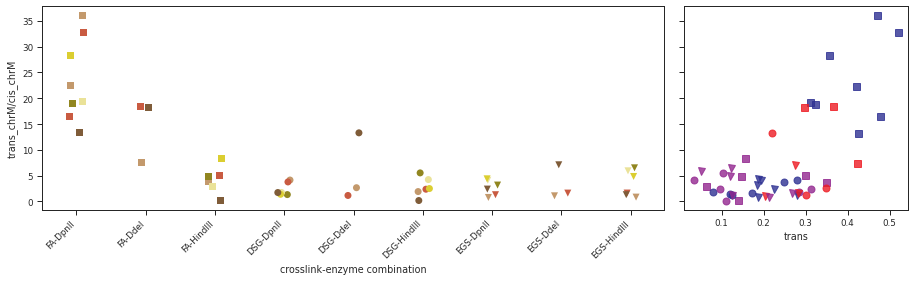

In [33]:

fig1 = plt.figure(figsize=(7*1.8,2*1.9),constrained_layout=True)
gs = fig1.add_gridspec(1,2, width_ratios=[5,1.8])
ax1 = fig1.add_subplot(gs[0])
ax2 = fig1.add_subplot(gs[1])


chrom="chrM"
cells_here = ['END','ESC','HelaS3','HFF']
enzymes_here = ["DpnII","DdeI","HindIII"]
crosslink_here = ["FA","DSG","EGS"]
cycle_here = ['NS','G1','M']

# prep the data with selected cell/enz/cross etc and normalized metrics for a given chrom (chrM for random ligation est.):
loc_df = prepare_plotting_data(enzymes_here, cells_here, cycle_here, crosslink_here,
                               chrom=chrom,
                               counts=["cis_chrom","trans_chrom","cis","trans","frac_tc"], # counts to be used in the metrics
                               normalized = True
                              )
grp = loc_df.groupby(by=["crosslink","enzyme"])


### some manual controls of the visuals:
jitter = 0.1
delta = 0.5
sns.set()
sns.set_context("paper")
sns.set_style("ticks")

marker_dict = {}
marker_dict["EGS"] = "v"
marker_dict["DSG"] = "o"
marker_dict["FA"] = "s"

color_dict = {}
color_dict["MNase"] = "#009444"
color_dict["DpnII"] = "#2E3192"
color_dict["DdeI"] = "#ED1C24"
color_dict["HindIII"] = "#92278F"

cell_colors = {
    'END-NS':"#C3996C",
    'ESC-NS':"#C95B41",
    'HFF-NS':"#7F5C39",
    'HelaS3-NS':"#DBCE31",
    'HelaS3-G1':"#918620",
    'HelaS3-M':"#EAE298"
}

linear_marker_size = 7

# stripplot for transM normalized by cisM
y_lab = "frac_tc"
idx = 0
x_ticks = []
x_ticklabels = []
for cross in ["FA","DSG","EGS"]:
    for enz in enzymes_here:
        grp_df = grp.get_group((cross,enz))
        x_ticks.append(idx)
        x_ticklabels.append(f"{cross}-{enz}")
        x = idx +rrr2(len(grp_df),jitter,delta)
        y = grp_df[y_lab]
        c = []
        for cell_cycle in grp_df[["cell","cycle"]].agg("-".join,axis=1):
            c.append(cell_colors[cell_cycle])
        m = marker_dict[cross]
        ax1.scatter(x,y,color=c,marker=m,s=linear_marker_size**2,linewidth=0)
        idx += 1
ax1.set_ylabel(f"trans_{chrom}/cis_{chrom}")
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_ticklabels,rotation=45, ha="right")
ax1.set_xlabel("crosslink-enzyme combination")


# scatter plot for transM normalized by cisM vs trans
y_lab = "frac_tc"
x_lab = "trans"
for cross in ["FA","DSG","EGS"]:
    for enz in enzymes_here:
        grp_df = grp.get_group((cross,enz))
        x = grp_df[x_lab]
        y = grp_df[y_lab]
        c = color_dict[enz]
        m = marker_dict[cross]
        ax2.plot(x,y,color=c,marker=m,markersize=linear_marker_size,linewidth=0,alpha=0.8)
ax2.set_xlabel("trans")


ax2.axes.yaxis.set_ticklabels([])
ax2.set_ylabel("")


plt.savefig(f"pub_trans_{chrom}_plot.pdf")

### a figure for revisions - the one only for deep-data
also inculding the double digest

In [103]:
### just showing ALL available celllines/enzymes and crosslinkers:
for c in cell_cycle_cross_enzyme.columns:
    print(c,cell_cycle_cross_enzyme[c].unique())
# what's up with the double digest
print(cell_cycle_cross_enzyme[cell_cycle_cross_enzyme["enzyme"]=="DdeI-DpnII"])
# this is how cell lines were called for the deep data cases
# here we'll have relevant combinations for the figure:
deep_cells = ["HFFc6","HFFc64DN","H1ESC4DN","ESC4DN","END4DN"]
cell_cycle_cross_enzyme[ cell_cycle_cross_enzyme["cell"]. \
                        isin(deep_cells) & (cell_cycle_cross_enzyme["enzyme"]!="MNase")  ]

cell ['END' 'ESC' 'HelaS3' 'HFF' 'PFE' 'HeLa' 'END4DN' 'ENDMaehr' 'ESC4DN'
 'H1ESC4DN' 'hEND4DN' 'HFFc64DN' 'HFFc6']
cycle ['NS' 'G1' 'M']
crosslink ['DSG' 'EGS' 'FA']
enzyme ['DdeI' 'DpnII' 'HindIII' 'MNase' 'NcoI' 'MboI' 'MflI' 'NheI' 'PspXI'
 'SgrAI' 'SgrDI' 'DdeI-DpnII']
      cell cycle crosslink      enzyme
128  HFFc6    NS       DSG  DdeI-DpnII
129  HFFc6    NS       DSG  DdeI-DpnII
130  HFFc6    NS       DSG  DdeI-DpnII


,cell,cycle,crosslink,enzyme
94,ESC4DN,NS,DSG,DpnII
95,ESC4DN,NS,DSG,DpnII
96,ESC4DN,NS,FA,DpnII
97,ESC4DN,NS,FA,DpnII
126,HFFc6,NS,DSG,DdeI
127,HFFc6,NS,DSG,DdeI
128,HFFc6,NS,DSG,DdeI-DpnII
129,HFFc6,NS,DSG,DdeI-DpnII
130,HFFc6,NS,DSG,DdeI-DpnII
131,HFFc6,NS,DSG,DpnII


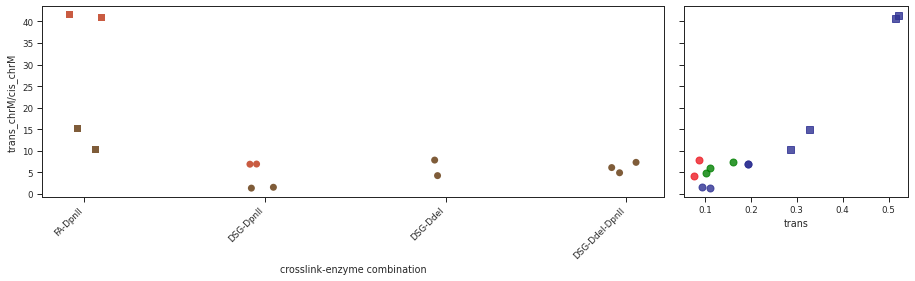

In [100]:

fig1 = plt.figure(figsize=(7*1.8,2*1.9),constrained_layout=True)
gs = fig1.add_gridspec(1,2, width_ratios=[5,1.8])
ax1 = fig1.add_subplot(gs[0])
ax2 = fig1.add_subplot(gs[1])

deep_cells = ["HFFc6","HFFc64DN","H1ESC4DN","ESC4DN","END4DN"]

chrom="chrM"
cells_here = deep_cells
enzymes_here = ["DpnII","DdeI","DdeI-DpnII"]
crosslink_here = ["FA","DSG","EGS"]
cycle_here = ['NS','G1','M']

# prep the data with selected cell/enz/cross etc and normalized metrics for a given chrom (chrM for random ligation est.):
loc_df = prepare_plotting_data(enzymes_here, cells_here, cycle_here, crosslink_here,
                               chrom=chrom,
                               counts=["cis_chrom","trans_chrom","cis","trans","frac_tc"], # counts to be used in the metrics
                               normalized = True
                              )
grp = loc_df.groupby(by=["crosslink","enzyme"])


### some manual controls of the visuals:
jitter = 0.1
delta = 0.5
sns.set()
sns.set_context("paper")
sns.set_style("ticks")

marker_dict = {}
marker_dict["EGS"] = "v"
marker_dict["DSG"] = "o"
marker_dict["FA"] = "s"

color_dict = {}
color_dict["MNase"] = "#009444"
color_dict["DpnII"] = "#2E3192"
color_dict["DdeI"] = "#ED1C24"
color_dict["DdeI-DpnII"] = "green"

cell_colors = {
    #     'END-NS':"#C3996C",
    #     'ESC-NS':"#C95B41",
    #     'HFF-NS':"#7F5C39",
    #     'HelaS3-NS':"#DBCE31",
    #     'HelaS3-G1':"#918620",
    #     'HelaS3-M':"#EAE298"
    'END4DN-NS':"#C3996C",
    'ESC4DN-NS':"#C95B41",
    'H1ESC4DN-NS':"#C95B41",
    'HFFc64DN-NS':"#7F5C39",
    'HFFc6-NS':"#7F5C39",
}



linear_marker_size = 7

# stripplot for transM normalized by cisM
y_lab = "frac_tc"
idx = 0
x_ticks = []
x_ticklabels = []
for cross in ["FA","DSG","EGS"]:
    for enz in enzymes_here:
        try:
            grp_df = grp.get_group((cross,enz))
        except KeyError:
            continue
        x_ticks.append(idx)
        x_ticklabels.append(f"{cross}-{enz}")
        x = idx +rrr2(len(grp_df),jitter,delta)
        y = grp_df[y_lab]
        c = []
        for cell_cycle in grp_df[["cell","cycle"]].agg("-".join,axis=1):
            c.append(cell_colors[cell_cycle])
        m = marker_dict[cross]
        ax1.scatter(x,y,color=c,marker=m,s=linear_marker_size**2,linewidth=0)
        idx += 1
ax1.set_ylabel(f"trans_{chrom}/cis_{chrom}")
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_ticklabels,rotation=45, ha="right")
ax1.set_xlabel("crosslink-enzyme combination")

# scatter plot for transM normalized by cisM vs trans
y_lab = "frac_tc"
x_lab = "trans"
for cross in ["FA","DSG","EGS"]:
    for enz in enzymes_here:
        try:
            grp_df = grp.get_group((cross,enz))
        except KeyError:
            continue
        x = grp_df[x_lab]
        y = grp_df[y_lab]
        c = color_dict[enz]
        m = marker_dict[cross]
        ax2.plot(x,y,color=c,marker=m,markersize=linear_marker_size,linewidth=0,alpha=0.8)
ax2.set_xlabel("trans")


ax2.axes.yaxis.set_ticklabels([])
ax2.set_ylabel("")


plt.savefig(f"revision_{chrom}_plot.pdf")